getting tensorfow datasets

In [1]:
!pip install -U tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


importing dependecies

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import math
import numpy as np
import matplotlib.pyplot as plt
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)


Getting the Fashion MNIST

In [2]:
dataset,metadata = tfds.load('fashion_mnist',as_supervised=True,with_info=True)

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
train_dataset,test_dataset = dataset['train'],dataset['test']

In [4]:
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Explore the Data

In [5]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


Preprocessing of Data

In [6]:
def normalize(images,labels):
  images = tf.cast(images,tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

Explore the preprocessed data

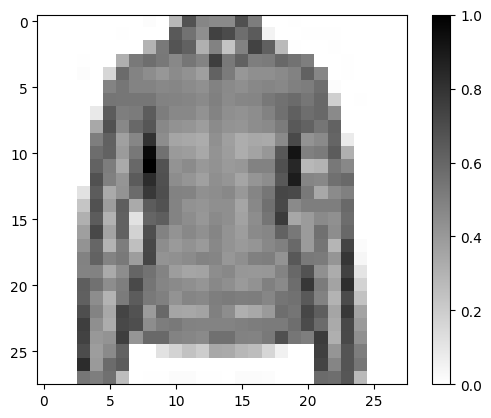

In [7]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

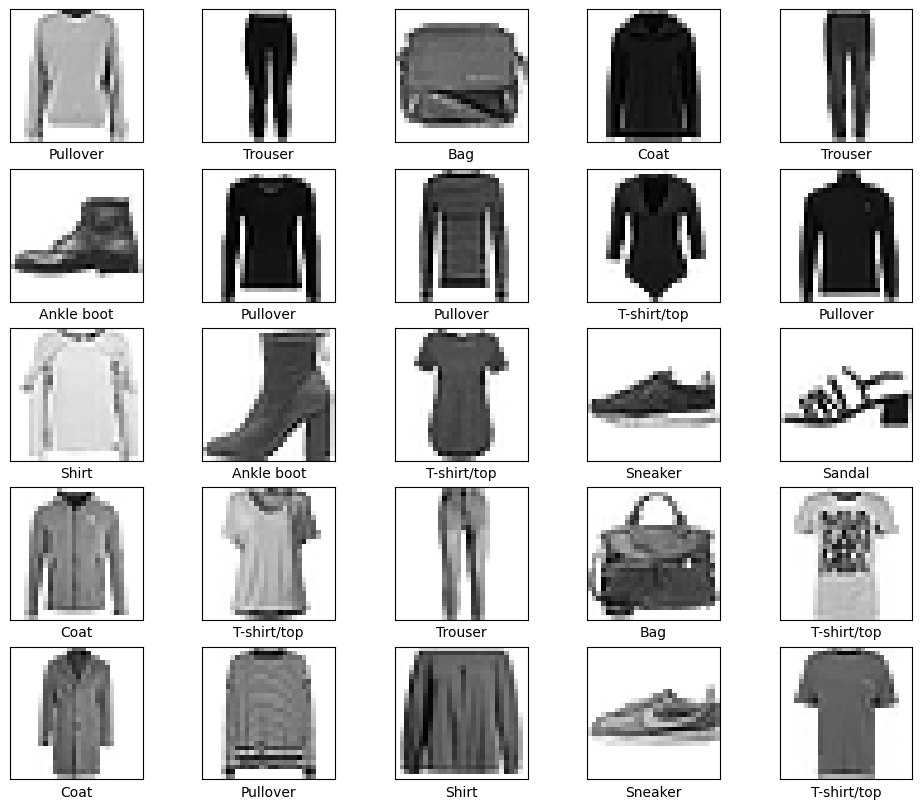

In [8]:
plt.figure(figsize=(12,10))
for i, (image, label) in enumerate(train_dataset.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

**Build the model**

Set up the layers

In [9]:
from keras.layers.attention.multi_head_attention import activation
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28,28,1)),
    tf.keras.layers.Dense(128,activation = tf.nn.relu),
    tf.keras.layers.Dense(10,activation = tf.nn.softmax)
])

Compile the model

In [10]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics='accuracy')

Train the model

In [11]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [13]:
model.fit(train_dataset, epochs=50, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2731 - accuracy: 0.9000
Epoch 2/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2702 - accuracy: 0.8997
Epoch 3/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2517 - accuracy: 0.9068
Epoch 4/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2464 - accuracy: 0.9086
Epoch 5/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2374 - accuracy: 0.9111
Epoch 6/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2298 - accuracy: 0.9136
Epoch 7/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2190 - accuracy: 0.9189
Epoch 8/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2120 - accuracy: 0.9212
Epoch 9/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2123 - accuracy: 0.9200
Epoch 10/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.200

Evaluate accuracy

In [14]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 4ms/step - loss: 0.5490 - accuracy: 0.8846
Accuracy on test dataset: 0.8845999836921692


Make predictions and explore

In [15]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 92ms/step


In [16]:
predictions.shape

(32, 10)

In [18]:
predictions[0]

array([4.26436027e-14, 3.99848811e-16, 1.79840761e-04, 1.32626376e-17,
       9.99419451e-01, 6.63016125e-19, 4.00749879e-04, 1.36540523e-20,
       4.60508944e-14, 5.71246474e-14], dtype=float32)

In [19]:
np.argmax(predictions[0])

4

In [20]:
test_labels[0]

4

In [21]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

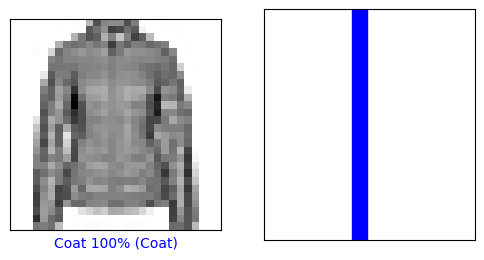

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

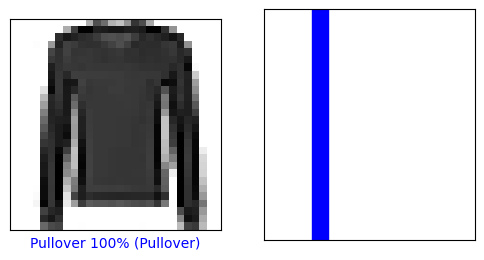

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

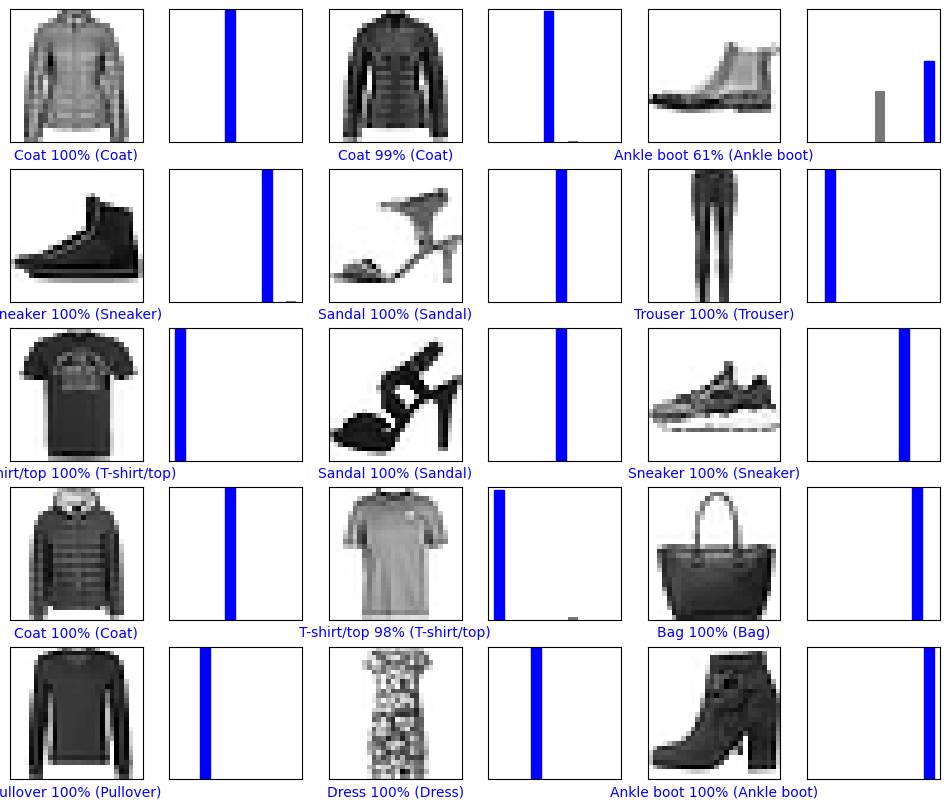

In [24]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

Finally, use the trained model to make a prediction about a single image.

In [25]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [26]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [27]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 185ms/step
[[4.26435214e-14 3.99848811e-16 1.79840761e-04 1.32626376e-17
  9.99419451e-01 6.63011059e-19 4.00750258e-04 1.36540523e-20
  4.60508944e-14 5.71245389e-14]]


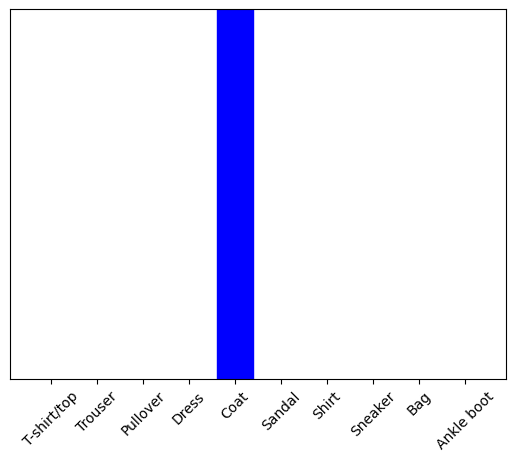

In [28]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [29]:
np.argmax(predictions_single[0])

4